In [154]:
import gdal
import numpy as np
import matplotlib.pyplot as plt

import fiona
import rasterio
import rasterio.mask

In [155]:
imgf = 'U:\\Training\\29_Raw_Training_Set_LVille_WD\\03_ANALYSIS\ANALYSIS_ZONE_Lville\\02_MOSAICS\\LVille_REF_Mosaic_PCI'

In [156]:
ds = gdal.Open(imgf)

In [157]:
bands = ds.RasterCount
data = np.array([ds.GetRasterBand(x+1).ReadAsArray() for x in range(bands)])
print(bands)

1


In [158]:
bands = ds.RasterCount
data = np.array([ds.GetRasterBand(x + 1).ReadAsArray() for x in range(bands)])
    

In [159]:
b, r, c = data.shape

In [160]:
new_data = data.reshape(b,-1).T

In [161]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [162]:
answer = np.random.randint(4,size=new_data.shape[0]).reshape(r, c)

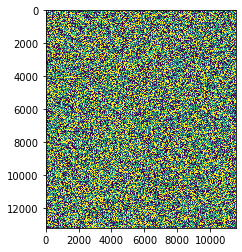

In [163]:
plt.imshow(answer)
plt.show()

### Masking/Extracting Raster Data using a shapefile
######https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html

In [164]:

shpf = 'U:\\Training\\29_Raw_Training_Set_LVille_WD\\00_PRELIM\\GROUND_TRUTH_DATA\\03_TRAINING_POLYGONS\\LVille_WGS84_UTM16N_Trees_POLYS_corrected_Code_2.shp'
class_field = 'Code_5'
tv_field = 'TV_1'
with fiona.open(shpf, "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    class_labels = [feature['properties'][class_field] for feature in shapefile]
    tv_labels = [feature['properties'][tv_field] for feature in shapefile]

    

In [165]:
training_data = []
training_labels = []
training_tv = []

with rasterio.open(imgf) as src:
    # Get the number of bands in the image
    bands = src.count
    # Loop through the list of features (shapes from the shapefile)
    for f in range(len(features)):
        #For each shape in features, use the shape to extract the pixel bbox around the shape
        image, image_transform = rasterio.mask.mask(src, [features[f]],crop=True)
        # Do the same thing, but this time create a binary mask of the bbox 0's mean pixel is inside the shape
        mask, mask_transform, mask_Window = rasterio.mask.raster_geometry_mask(src, [features[f]],crop=True)
        
        # Invert the mask so we can select pixels where mask == 1  (this is just more intuitive)
        mask = 1- (1* mask)
        # Reshape the mask
        mask = np.ravel(mask)
        
        # Reshape the image array
        image = image.reshape(bands,-1).T
        
        # Select only pixels where mask == 1 (pixels inside the given shape)
        data = image[mask == 1]
        
        # Use list comprehension to create a list of lists where the internal list is the band values for each pixel
        # Example:
        # px1  [[wv1, wv2, wv3, wv4, wv5, wv6, wv7],
        # px2   [wv1, wv2, wv3, wv4, wv5, wv6, wv7],
        # px3   [wv1, wv2, wv3, wv4, wv5, wv6, wv7],
        # px3   [wv1, wv2, wv3, wv4, wv5, wv6, wv7]]
        training_data += [list(px) for px in data]
        # Do the same for training labels
        training_labels += [class_labels[f]] * data.shape[0]
        # Do the same for validation labels
        training_tv += [tv_labels[f]] * data.shape[0]
        
# Turn all these into arrays
training_data = np.array(training_data)
training_labels = np.array(training_labels)
training_tv = np.array(training_tv)

In [166]:
# Create a random forest classifier object (there are more advanced way of doing this -- see Grid SearchCV)
clf = RandomForestClassifier(n_estimators=500,oob_score=True,max_depth=2,random_state=0)
X_train, X_test, y_train, y_test = train_test_split(training_data, training_labels, test_size=0.33, random_state=42)

In [167]:
model = clf.fit(X_train, y_train) 

In [168]:
model.predict(new_data)

array([4, 4, 4, ..., 4, 4, 4])

In [169]:
answers = model.predict(X_test)

In [170]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, answers)

array([[    0,     0,     0, 20056],
       [    0,     0,     0,  8335],
       [    0,     0,     0,  1756],
       [    0,     0,     0, 45516]], dtype=int64)

#### Now classify the whole thing

In [171]:
with rasterio.open(imgf) as src:
    b = src.count
    r = src.height
    c = src.width
    
    out_profile = src.profile
    whole_image = src.read()

# Reshape the image so you can ingest to RF
whole_image = whole_image.reshape(b,-1).T

In [ ]:
#Send through the RF
all_answers = model.predict(whole_image)

In [135]:
# Reshape the answer to the og image shape
final = all_answers.reshape(r,c)

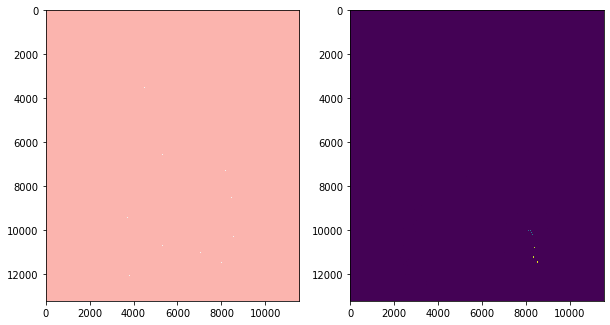

In [136]:
#Plot it
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(final, cmap='Pastel1')


plt.subplot(122)
plt.imshow(whole_image.T.reshape(b,r,c)[0])
plt.show()

In [137]:
# Write to a new file using the profile you grabbed when you opened the image
out_profile.update(count=1,dtype=rasterio.uint8)
output_file = imgf+"_classed"
with rasterio.open(output_file, 'w', **out_profile) as dst:
        dst.write(final.astype(rasterio.uint8), 1)

In [138]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=clf.oob_score_ * 100))

Our OOB prediction of accuracy is: 40.26012915321321%


In [139]:
bands = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for b, imp in zip(bands, clf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.0038102123130663813
Band 2 importance: 0.017249161546313233
Band 3 importance: 0.007799051417092163
Band 4 importance: 0.02478801987278489
Band 5 importance: 0.13453997366933676
Band 6 importance: 0.1126824866056974
Band 7 importance: 0.18427809059593284
Band 8 importance: 0.04920974911422529
Band 9 importance: 0.13509418460384393
Band 10 importance: 0.04377916263689559
Band 11 importance: 0.10211119347543725
Band 12 importance: 0.0
Band 13 importance: 0.0005788875638822688
Band 14 importance: 0.0
Band 15 importance: 0.0
